In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

import scanpy as sc
import anndata as ad


from scipy.sparse import csr_matrix
import pandas as pd
import anndata as ad


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experimnet

### Load data 

In [4]:
# df_meta : E14_5 SMOM2 CTL meta data
# df : E14_5 SMOM2 CTL raw data

In [8]:
cell_types= np.array(df_meta['celltype'].values)
phase_types= np.array(df_meta['Phase'].values)

In [9]:
print(np.unique(cell_types))
print(np.unique(phase_types))

['DC' 'LD' 'UD']
['G1' 'G2M' 'S']


In [ ]:
x_orig= df.values.T[1:]
gene_names_orig=  df.values.T[0]

# Preprocess data

In [10]:
x_adata = ad.AnnData(x_orig+0.)
sc.pp.normalize_total(x_adata,target_sum=1e6)
sc.pp.log1p(x_adata)
sc.pp.highly_variable_genes(x_adata,n_top_genes=5000)
sc.pp.scale(x_adata)


In [11]:
x = x_adata.X[:,np.where(x_adata.var['highly_variable'])[0]]+0.
gene_names = gene_names_orig[x_adata.var['highly_variable'].index.to_numpy()[np.where(x_adata.var['highly_variable'])].astype(int)]

x.shape

(5598, 5000)

In [12]:
from collections import Counter
print(Counter(cell_types))
print(Counter(phase_types))


Counter({'UD': 3517, 'LD': 1732, 'DC': 349})
Counter({'G1': 2765, 'G2M': 1428, 'S': 1405})


## Choose rank

In [15]:
from FP import *

In [17]:
x_SVD = SVD_mean_shifted( x,500)
x_new_SVD= (x_SVD[0][::,:50], x_SVD[1][:50], x_SVD[2][:50,:])

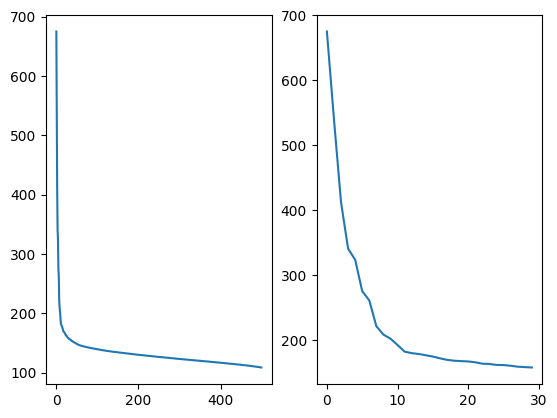

In [18]:
f,ax= plt.subplots(1,2)
ax[0].plot(x_SVD[1])
ax[1].plot(x_SVD[1][:30])

# run algorithm

In [22]:
K=2
perplexity=40

verbose_updates= True


FP_K2 = FP(K=K, perplexity=perplexity)


In [ ]:
FP_K2.fit(x_new_SVD, verbose_updates= verbose_updates, simulations=100)


# Visualization

In [ ]:
feat_partitions = FP_K2.get_feature_partitions()

In [ ]:
emb_all = TSNE(n_components=3, perplexity=30, random_state=42).fit_transform(x_new_SVD[0]*x_new_SVD[1])
emb_ours = [ TSNE(n_components=3, perplexity=30, random_state=42).fit_transform((x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]]) for i in range(K)]


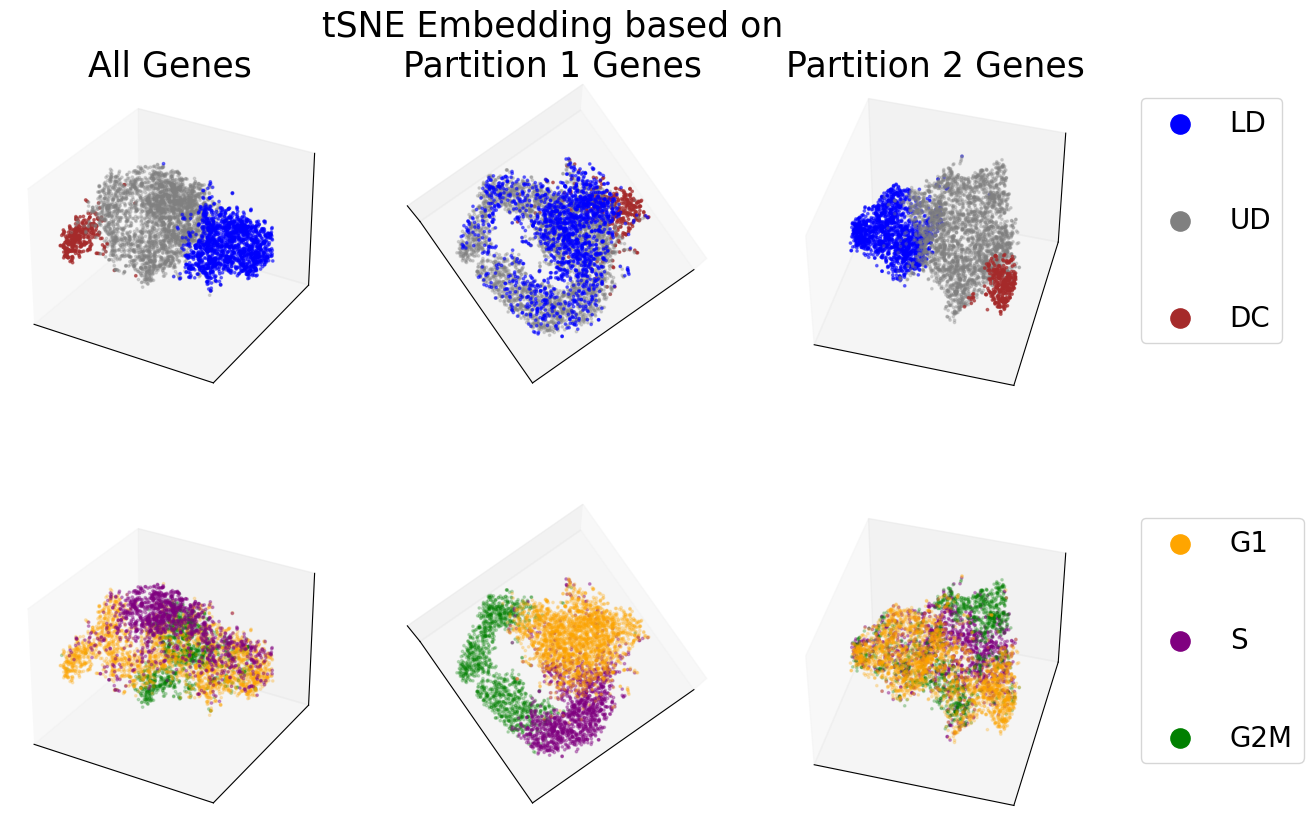

In [48]:
colors1= ['blue','grey','brown']
colors2= ['orange','purple','green']
alpha=0.1
s=3

f,ax= plt.subplots(2,3,figsize=(14,10),subplot_kw={'projection':'3d'})
for i,l in enumerate(['LD','UD','DC']):
    alpha=[0.7,0.4,0.9][i]*0.7

    inds= np.where(np.array(cell_types)==l)[0]
    ax[0,0].scatter(emb_all[inds,0],emb_all[inds,1],emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,1].scatter(emb_ours[0][inds,0],emb_ours[0][inds,1],emb_ours[0][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,2].scatter(emb_ours[1][inds,0],emb_ours[1][inds,1],emb_ours[1][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])

for i,l in enumerate(['G1','S','G2M']):
    alpha=[0.3,0.5,0.3][i]*0.7

    inds= np.where(np.array(phase_types)==l)[0]
    ax[1,0].scatter(emb_all[inds,0],emb_all[inds,1],emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,1].scatter(emb_ours[0][inds,0],emb_ours[0][inds,1],emb_ours[0][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,2].scatter(emb_ours[1][inds,0],emb_ours[1][inds,1],emb_ours[1][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])

l1= ax[0,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.1, 1),fontsize=20,labelspacing=2.5)
l2= ax[1,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.1, 1),fontsize=20,labelspacing=2.5)

for lh in l1.legend_handles: 
    lh.set_alpha(1)
for lh in l2.legend_handles: 
    lh.set_alpha(1)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.set_zticks([])


ax[0,0].set_title('All Genes',fontsize=25)
ax[0,1].set_title('tSNE Embedding based on\nPartition 1 Genes',fontsize=25)
ax[0,2].set_title('Partition 2 Genes',fontsize=25)


ax[0,2].view_init(45,105)
ax[1,2].view_init(45,105)
ax[0,1].view_init(85,55)
ax[1,1].view_init(85,55)

# Genes Analysis

In [ ]:
W= FP_K2.get_optimal_parameters()['W']

In [41]:
wanted_genes= np.array([np.where(gene_names =='Foxd1' ),\
                       np.where(gene_names =='Sox2' ),\
                       np.where(gene_names =='Mki67' ),\
                       np.where(gene_names =='Ccna2' ),\
                       np.where(gene_names =='Ptch1' ),\
                       np.where(gene_names =='Lef1' )]).flatten()
wanted_genes
for i in wanted_genes:
    for j in range(K):
        if (i in feat_partitions[j]):
            print(j) 

1
1
0
0
1
1


In [42]:
from scipy.spatial.distance import pdist,squareform
def LaplacianScore(W,x, isZscored=True):
    if not isZscored:
        return np.mean(np.sum(W+W.T,axis=1,keepdims=True)*x**2,axis=0) -2* np.mean((W@x)*x,axis=0)   
    
    newX= (x-np.mean(x,axis=0,keepdims=True))/(1e-10+ np.std(x,axis=0,keepdims=True))
    
    
    res= np.mean(np.sum(W+W.T,axis=1,keepdims=True)*newX**2,axis=0) -2* np.mean((W@newX)*newX,axis=0)
    res[np.where(np.std(x,axis=0)<1e-10)[0]]=1e10
    return res

In [43]:
cur_gene_indes =[]
score_genes = []

for i in range(K):

    cur_scores= LaplacianScore(W[i], (x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]], isZscored=True)
    cur_genes=  feat_partitions[i][np.argsort(cur_scores)]
    cur_scores= np.sort(cur_scores)

    cur_gene_indes.append( cur_genes+0)
    score_genes.append( cur_scores+0)

In [45]:
for i in range(K):
    print(np.array(gene_names)[cur_gene_indes[i][:40]])

['Ckap2l' 'Cenpf' 'Ccna2' 'Ube2c' 'Top2a' 'Prc1' 'Kif22' 'Nusap1' 'Cdca8'
 'Tpx2' 'Hmmr' 'Spc25' 'Kif23' 'Incenp' 'Shcbp1' 'Sgo2a' 'Ccnb1' 'Ndc80'
 'Knl1' 'Cenpe' 'Racgap1' 'Ska1' 'Tacc3' 'Mki67' 'Cdca3' 'Mis18bp1' 'Anln'
 'Mxd3' 'Bub1' 'Spdl1' 'Pbk' 'Kif15' 'Aurkb' 'Kif11' 'Kif20b' 'Kif2c'
 'Dbf4' 'Pimreg' 'Knstrn' 'Smc4']
['Nrk' 'Itm2a' 'Agtr2' 'Plagl1' 'Abi3bp' 'Akap12' 'Ptn' 'Rbp1' 'Igf2'
 'Igfbp4' 'Dpt' 'Loxl1' 'Rarres2' 'Crabp1' 'Postn' 'Cdkn1c' 'Creb5'
 'Tmeff2' 'Lix1' 'Sfrp2' 'Tshz2' 'H19' 'Sema3c' 'Fibin' 'Angptl1' 'Thbs2'
 'Cd55' 'Rtl3' 'Dlk1' 'Bcl11b' 'Klf4' 'Kcnj8' 'Lox' 'Cavin2' 'Mfap5'
 'Zfhx4' 'Wnt2' 'Ogn' 'Arhgap20' 'Zeb2']


# Compare to Seurat cell-cycle genes

In [46]:
# Seurat's cell-cycle genes were extracted from R using the following R code:
# 
# library(Seurat)
# library(gprofiler2)
#
# genes_s = gorth(cc.genes.updated.2019$s.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_g2m = gorth(cc.genes.updated.2019$g2m.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_c = c(genes_s,genes_g2m)
# cat(paste(shQuote(genes_c), collapse = ","))

CC_genes= ['Mcm5','Pcna','Tyms','Fen1','Mcm7','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Cenpu','Hells','Rfc2','Polr1b','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Mrpl36','E2f8','Hmgb2','Cdk1','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Mki67','Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Jpt1','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa']

print('Number of Seurat CC phase Genes :'+str(len(CC_genes)))
print('Number of Seurat CC phase Genes after the preprocessing :'+str(len([a for a in CC_genes if a in gene_names])))
print('Number of Seurat CC phase Genes after the preprocessing within partition 1 :'+str(len([a for a in CC_genes if a in gene_names[feat_partitions[0]]])))
print()

Number of Seurat CC phase Genes :95
Number of Seurat CC phase Genes after the preprocessing :63
Number of Seurat CC phase Genes after the preprocessing within partition 1 :63

